In [183]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits

In [184]:
digits = load_digits()
x = digits.data
y = digits.target
n_samples, n_features = x.shape

In [185]:
batch_size = 500
n_batches = n_samples // batch_size

In [186]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [187]:
latent_dim = 2
n_hidden = 64
x = x[0]

In [188]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def forward_vae(x):
    input_size = x.shape[0]
    hidden_size = 4
    latent_size = 2

    # Encoder weights
    W1 = np.random.randn(hidden_size, input_size)
    b1 = np.zeros(hidden_size)

    # Mean and logvar layer weights
    W_mu = np.random.randn(latent_size, hidden_size)
    b_mu = np.zeros(latent_size)

    W_logvar = np.random.randn(latent_size, hidden_size)
    b_logvar = np.zeros(latent_size)

    # Decoder weights
    W3 = np.random.randn(hidden_size, latent_size)
    b3 = np.zeros(hidden_size)

    W4 = np.random.randn(input_size, hidden_size)
    b4 = np.zeros(input_size)

    # ---- Encoder ----
    h1 = relu(np.dot(W1, x) + b1)

    mu = np.dot(W_mu, h1) + b_mu
    logvar = np.dot(W_logvar, h1) + b_logvar

    # ---- Reparameterization Trick ----
    std = np.exp(0.5 * logvar)
    epsilon = np.random.randn(*std.shape)
    z = mu + epsilon * std

    # ---- Decoder ----
    h3 = relu(np.dot(W3, z) + b3)
    x_hat = sigmoid(np.dot(W4, h3) + b4)

    return x_hat, mu, logvar, z

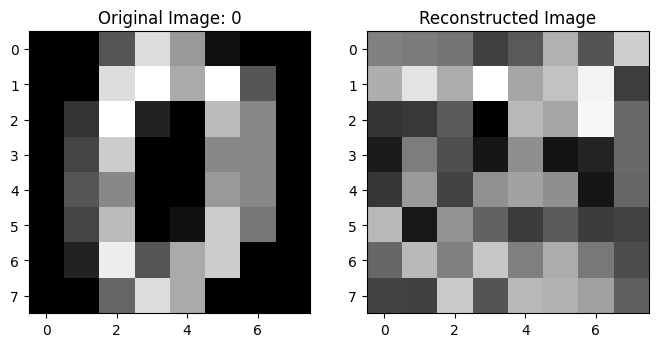

Latent vector z: [-7.93810814 -6.45994008]


In [189]:
x_hat, mu, logvar, z = forward_vae(x)

# print("Input x:", x)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.reshape(8, 8), cmap='gray')
plt.title("Original Image: " + str(y[0]))
# print("Reconstructed x:", x_hat)
plt.subplot(1, 2, 2)
plt.imshow(x_hat.reshape(8, 8), cmap='gray')
plt.title("Reconstructed Image")
plt.show()
print("Latent vector z:", z)

In [190]:
def vae_forward(x):
    # Encoder weights (3 input → 2 hidden)
    W_enc = np.array([[0.1, 0.2, 0.3],
                      [0.4, 0.5, 0.6]])
    b_enc = np.array([0.0, 0.0])
    
    # Separate weights for mean and logvar (2 hidden → 2 latent)
    W_mu = np.array([[0.2, 0.1],
                     [0.3, 0.4]])
    b_mu = np.array([0.1, -0.1])

    W_logvar = np.array([[0.1, -0.2],
                         [0.05, 0.3]])
    b_logvar = np.array([-0.2, 0.2])

    # Decoder (2 latent → 3 output)
    W_dec = np.array([[0.1, 0.2],
                      [0.3, 0.4],
                      [0.5, 0.6]])
    b_dec = np.array([0.0, 0.0, 0.0])
    
    # Encoder forward pass
    h = relu(np.dot(W_enc, x) + b_enc)   # (2,)
    
    mu = np.dot(W_mu, h) + b_mu          # (2,)
    logvar = np.dot(W_logvar, h) + b_logvar  # (2,)

    std = np.exp(0.5 * logvar)
    epsilon = np.random.randn(*std.shape)
    z = mu + std * epsilon               # Reparameterization

    x_hat = sigmoid(np.dot(W_dec, z) + b_dec)

    return x_hat, z, mu, logvar

In [191]:
x = np.array([0.5, 0.2, 0.9])
x_hat, z, mu, logvar = vae_forward(x)

print("Input x:", x)
print("Mean (μ):", mu)
print("Logvar:", logvar)
print("Sampled z:", z)
print("Reconstructed x_hat:", x_hat)

Input x: [0.5 0.2 0.9]
Mean (μ): [0.256 0.344]
Logvar: [-0.332  0.47 ]
Sampled z: [ 0.35675349 -0.86091211]
Reconstructed x_hat: [0.46592613 0.44094227 0.41625395]


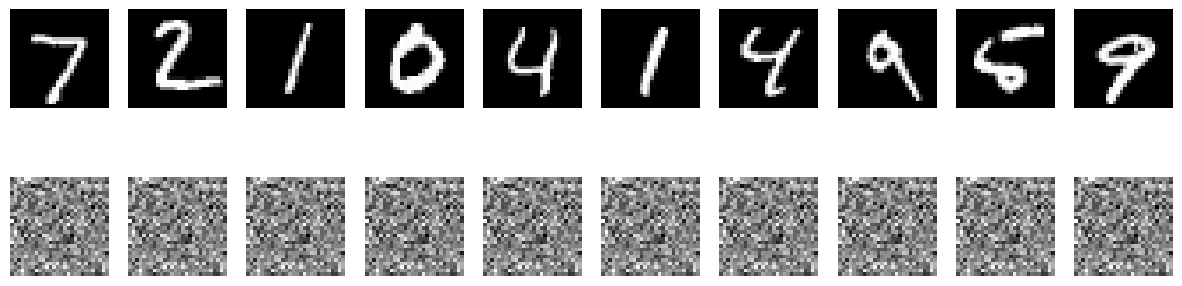

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0    # Normalize to [0, 1]

# Flatten the 28x28 images into 784-dimensional vectors
x_train_flat = x_train.reshape((-1, 28 * 28))
x_test_flat = x_test.reshape((-1, 28 * 28))

# Hyperparameters
input_size = 28 * 28  # 784 pixels per image
latent_size = 32      # Latent space size

# Initialize weights and biases (encoder and decoder)
def initialize_variables():
    W_enc = np.random.randn(input_size, latent_size) * 0.01  # Encoder weights
    b_enc = np.zeros((latent_size,))                          # Encoder biases
    W_dec = np.random.randn(latent_size, input_size) * 0.01  # Decoder weights
    b_dec = np.zeros((input_size,))                           # Decoder biases
    return W_enc, b_enc, W_dec, b_dec

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Encoder: Map input to latent space
def encoder(x, W_enc, b_enc):
    return sigmoid(np.dot(x, W_enc) + b_enc)  # Sigmoid activation

# Decoder: Reconstruct input from latent space
def decoder(z, W_dec, b_dec):
    net = sigmoid(np.dot(z, W_dec) + b_dec)  # Sigmoid activation
    return net / 255.0

# Perform the forward pass on the test data
def forward_pass(x, W_enc, b_enc, W_dec, b_dec):
    # Encoder: Compress input into latent space
    z = encoder(x, W_enc, b_enc)  # Latent representation
    # Decoder: Reconstruct the input
    x_reconstructed = decoder(z, W_dec, b_dec)  # Reconstructed input
    return x_reconstructed

# Initialize variables (weights and biases)
W_enc, b_enc, W_dec, b_dec = initialize_variables()

# Perform a forward pass on the first 10 test samples
x_test_sample = x_test_flat[:10]
x_reconstructed = forward_pass(x_test_sample, W_enc, b_enc, W_dec, b_dec)

# Reshape the reconstructed images and original images back to 28x28 for visualization
x_reconstructed_reshaped = x_reconstructed.reshape(-1, 28, 28)
x_test_sample_reshaped = x_test[:10].reshape(-1, 28, 28)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x_test_sample_reshaped[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_reconstructed_reshaped[i], cmap='gray')
    axes[1, i].axis('off')
plt.show()